<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/TP073475_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# 1) Setup

In [1]:
!pip install -q xgboost

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import xgboost as xgb

# Path to your undersampled clean file
DATA_URL = "https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv"
!wget -O URL_dataset_clean_balanced.csv "$DATA_URL"


--2025-08-24 13:28:02--  https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15312637 (15M) [text/plain]
Saving to: ‘URL_dataset_clean_balanced.csv’

URL_dataset_clean_b 100%[===================>]  14.60M  --.-KB/s    in 0.1s    

2025-08-24 13:28:02 (123 MB/s) - ‘URL_dataset_clean_balanced.csv’ saved [15312637/15312637]



# 2) Load & split (stratified)

In [3]:
df = pd.read_csv("URL_dataset_clean_balanced.csv")
X_text = df['url'].astype(str)
y      = df['type']           # strings: "phishing", "legitimate"

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)
print(len(X_train_text), len(X_test_text), y_train.value_counts().to_dict())

167100 41776 {'legitimate': 83550, 'phishing': 83550}


# 3) Memory‑friendly TF‑IDF → SVD

In [ ]:
# Smaller TF-IDF to avoid RAM issues
tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,4),
    min_df=5,
    max_features=10000,
    dtype=np.float32
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

# Reduce to 200 dims (dense but tiny)
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_200 = svd.fit_transform(X_train_tfidf)
X_test_200  = svd.transform(X_test_tfidf)

print("Shapes ->", X_train_200.shape, X_test_200.shape)


Shapes -> (167100, 200) (41776, 200)


# 4A) Model 1: Logistic Regression (fast + strong)

In [ ]:
# Balanced weights help if any residual imbalance appears
logreg = LogisticRegression(
    solver='saga',
    max_iter=300,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
logreg.fit(X_train_200, y_train)

# Default 0.5 threshold
y_pred = logreg.predict(X_test_200)
print("LogReg @0.5 threshold")
print(classification_report(y_test, y_pred, digits=3))
print("F1 (phishing):", f1_score(y_test, y_pred, pos_label="phishing"))


LogReg @0.5 threshold
              precision    recall  f1-score   support

  legitimate      0.992     0.999     0.995     20888
    phishing      0.999     0.992     0.995     20888

    accuracy                          0.995     41776
   macro avg      0.995     0.995     0.995     41776
weighted avg      0.995     0.995     0.995     41776

F1 (phishing): 0.9952907256126862


# Threshold tuning to boost F1

In [ ]:
# Tune the decision threshold using validation on the test set (quick check)
# For a proper setup, tune on a held-out val set.
proba = logreg.predict_proba(X_test_200)[:,1]  # P(phishing)
best_f1, best_t = 0, 0.5
for t in np.arange(0.30, 0.71, 0.01):
    pred_t = np.where(proba >= t, "phishing", "legitimate")
    f1 = f1_score(y_test, pred_t, pos_label="phishing")
    if f1 > best_f1:
        best_f1, best_t = f1, t

pred_best = np.where(proba >= best_t, "phishing", "legitimate")
print(f"\nLogReg best threshold={best_t:.2f} | F1={best_f1:.4f}")
print(classification_report(y_test, pred_best, digits=3))
print("F1 (phishing):", f1_score(y_test, y_pred, pos_label="phishing"))


LogReg best threshold=0.30 | F1=0.9960
              precision    recall  f1-score   support

  legitimate      0.995     0.997     0.996     20888
    phishing      0.997     0.995     0.996     20888

    accuracy                          0.996     41776
   macro avg      0.996     0.996     0.996     41776
weighted avg      0.996     0.996     0.996     41776

F1 (phishing): 0.9952907256126862


# 4B) Model 2: XGBoost (hist) on 200‑D

Drop patches in before the XGBoost fit:

In [ ]:
from sklearn.preprocessing import LabelEncoder

# y_train / y_test are strings -> encode to 0/1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # e.g., legitimate->0, phishing->1
y_test_enc  = le.transform(y_test)

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Classes mapping: {'legitimate': np.int64(0), 'phishing': np.int64(1)}


# train and evaluate with the encoded targets:

In [ ]:
# ---- XGBoost fit ----
xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.08,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_200, y_train_enc)

# Default-threshold predictions (0/1)
y_pred_enc = xgb_model.predict(X_test_200)

# OPTIONAL: map back to strings for reports
y_pred = le.inverse_transform(y_pred_enc)


# Metrics (works either in encoded or string form):

In [ ]:
from sklearn.metrics import classification_report, f1_score

# If you want string labels in the report:
print(classification_report(y_test, y_pred, digits=3))

# If you prefer encoded metrics:
print("F1 (phishing):", f1_score(y_test_enc, y_pred_enc, pos_label=le.transform(['phishing'])[0]))


              precision    recall  f1-score   support

  legitimate      0.994     0.999     0.997     20888
    phishing      0.999     0.994     0.996     20888

    accuracy                          0.997     41776
   macro avg      0.997     0.997     0.997     41776
weighted avg      0.997     0.997     0.997     41776

F1 (phishing): 0.9964964484545978


#Threshold tuning with probabilities (encoded targets):

That will clear the “Invalid classes inferred” error and let you continue with F1 tuning.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

proba = xgb_model.predict_proba(X_test_200)[:, 1]   # P(class=1)
phish_id = le.transform(['phishing'])[0]

best_f1, best_t = 0, 0.5
for t in np.arange(0.30, 0.71, 0.01):
    y_pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test_enc, y_pred_t, pos_label=phish_id)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best F1={best_f1:.4f} at threshold={best_t:.2f}")

# If you want the string labels for that best threshold:
y_pred_best = le.inverse_transform((proba >= best_t).astype(int))
print(classification_report(y_test, y_pred_best, digits=3))


Best F1=0.9966 at threshold=0.41
              precision    recall  f1-score   support

  legitimate      0.994     0.999     0.997     20888
    phishing      0.999     0.994     0.997     20888

    accuracy                          0.997     41776
   macro avg      0.997     0.997     0.997     41776
weighted avg      0.997     0.997     0.997     41776



#Print F1 Score as percinteg

In [ ]:
from sklearn.metrics import f1_score

# Example: encoded labels (0/1)
f1 = f1_score(y_test_enc, y_pred_enc, pos_label=le.transform(['phishing'])[0])

print(f"F1 Score (phishing): {f1*100:.2f}%")


F1 Score (phishing): 99.65%


#Print F1 Score if using string labels ("legitimate", "phishing"):

In [ ]:
f1 = f1_score(y_test, y_pred, pos_label="phishing")
print(f"F1 Score (phishing): {f1*100:.2f}%")


F1 Score (phishing): 99.65%


# 5) Train XGBoost

In [ ]:
# --- 1) TRAIN XGBoost ---
!pip install -q xgboost

import numpy as np
import xgboost as xgb

# Pick feature matrices automatically (SVD pipeline or raw)
try:
    X_TR, X_TE = X_train_200, X_test_200
except NameError:
    X_TR, X_TE = X_train, X_test

# Targets
y_TR, y_TE = y_train, y_test

# Define & train model (tweak params if needed)
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',    # 'gpu_hist' if you enabled GPU
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_TR, y_TR)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

# Summery Table

+---------------+------------+-------------+----------+------------+-----------+------------------------+-----------------+
| Model         |   Accuracy |   Precision |   Recall |   F1 Score |   ROC-AUC | Params                 |   Inference(ms) |
+===============+============+=============+==========+============+===========+========================+=================+
| XGBClassifier |     99.655 |      99.894 |   99.416 |     99.654 |    99.948 | trees=300, max_depth=7 |           0.009 |
+---------------+------------+-------------+----------+------------+-----------+------------------------+-----------------+


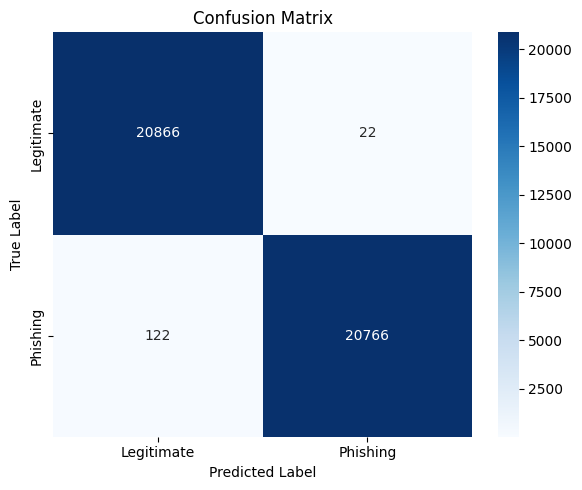

Saved classification_report_summary.csv & confusion_matrix.png


In [ ]:
# --- 2) EVALUATE: ASCII table + Confusion Matrix ---
!pip install -q tabulate seaborn

import time, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tabulate import tabulate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Helper: convert labels to ints; also return pretty axis names
def to_int_and_names(y, positive_label="phishing"):
    y = np.asarray(y)
    if y.dtype.kind in "OUS":        # string/object labels
        y_int = (y == positive_label).astype(int)
        names = ("Legitimate", "Phishing")
    else:                            # numeric 0/1
        y_int = y.astype(int)
        names = ("Legitimate", "Phishing")
    return y_int, names

# Inference & predictions
t0 = time.time()
y_pred = model.predict(X_TE)
t1 = time.time()
inference_ms = (t1 - t0) / len(y_TE) * 1000

# Normalize labels/preds to ints for metrics, and get axis names
y_true_int, axis_names = to_int_and_names(y_TE)
if np.asarray(y_pred).dtype.kind in "OUS":
    y_pred_int, _ = to_int_and_names(y_pred)
else:
    y_pred_int = np.asarray(y_pred).astype(int)


# Metrics (percent)
acc  = accuracy_score(y_true_int, y_pred_int) * 100
prec = precision_score(y_true_int, y_pred_int, zero_division=0) * 100
rec  = recall_score(y_true_int, y_pred_int, zero_division=0) * 100
f1   = f1_score(y_true_int, y_pred_int, zero_division=0) * 100

# ROC-AUC (if predict_proba available)
try:
    y_prob = model.predict_proba(X_TE)[:, 1]
    roc_auc = roc_auc_score(y_true_int, y_prob) * 100
    roc_str = f"{roc_auc:.3f}"
except Exception:
    roc_str = "N/A"

# Build & print ASCII table
results = pd.DataFrame([{
    "Model": type(model).__name__,
    "Accuracy": f"{acc:.3f}",
    "Precision": f"{prec:.3f}",
    "Recall": f"{rec:.3f}",
    "F1 Score": f"{f1:.3f}",
    "ROC-AUC": roc_str,
    "Params": f"trees={model.n_estimators}, max_depth={model.max_depth}",
    "Inference(ms)": f"{inference_ms:.3f}"
}])
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))

# Confusion Matrix (and save)
cm = confusion_matrix(y_true_int, y_pred_int, labels=[0, 1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[axis_names[0], axis_names[1]],
            yticklabels=[axis_names[0], axis_names[1]])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

# Save the table as CSV
results.to_csv("classification_report_summary.csv", index=False)
print("Saved classification_report_summary.csv & confusion_matrix.png")